In [1]:
import numpy as np

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from pastamarkers import pasta, salsa, add_parmesan

# # Enable better plots
# plt.style.use('ggplot')
# sns.set(font_scale=1.2)
# %matplotlib inline


In [3]:


# ## Define helper functions to extract metadata from filenames

def extract_energy_from_filename(filename):
    """Extract energy value and unit from the filename."""
    match = re.search(r'(\d+)([GMk]?eV)', filename)
    if match:
        return f"{match.group(1)}{match.group(2)}"
    return None

def extract_process_from_filename(filename):
    """Extract the process name from the filename."""
    for process in ["muIoni", "muBrems", "muonNuclear", "muPairProd"]:
        if process in filename:
            return process
    return None

def extract_timestamp_from_filename(filename):
    """Extract timestamp from the filename if available."""
    match = re.search(r'_(\d{8}_\d{6})\.', filename)
    if match:
        return match.group(1)
    return None

# ## Define the main scanning function

def scan_output_directories(base_path="/groups/icecube/jackp/g4mu/output_5000m", 
                           pattern="out_*", 
                           recursive=False):
    """
    Scan all directories matching the pattern and collect CSV data.
    Only process newer format files (with energy in filename) to avoid duplicates.
    """
    # Find all directories matching the pattern
    search_path = os.path.join(base_path, pattern)
    if recursive:
        dirs = glob.glob(search_path, recursive=True)
    else:
        dirs = glob.glob(search_path)
    
    print(f"Found {len(dirs)} directories matching the pattern '{pattern}'")
    
    # Initialize storage for different process types
    process_dfs = {
        "muIoni": [],
        "muBrems": [],
        "muonNuclear": [],
        "muPairProd": []
    }
    
    # Process each directory
    for dir_path in sorted(dirs):
        if not os.path.isdir(dir_path):
            continue
            
        dir_name = os.path.basename(dir_path)
        
        # Find all CSV files in the directory with the newer naming format
        # Only select files that have energy in the name (secondaries_100000GeV_*)
        csv_files = []
        all_csv_files = glob.glob(os.path.join(dir_path, "secondaries_*.csv"))
        
        # Filter to keep only the newer format files
        for file in all_csv_files:
            filename = os.path.basename(file)
            # Check if it matches the pattern secondaries_XXXGeV_processName_timestamp.csv
            if re.search(r'secondaries_\d+[GMk]?eV_\w+_\d{8}_\d{6}\.csv', filename):
                csv_files.append(file)
        
        # Skip directories with no CSV files
        if not csv_files:
            continue
        
        # Extract energy from directory name as fallback
        dir_energy = None
        energy_match = re.search(r'out_(\d+)([GMk]?eV)', dir_name)
        if energy_match:
            dir_energy = f"{energy_match.group(1)}{energy_match.group(2)}"
        
        # Process each CSV file
        for csv_file in csv_files:
            filename = os.path.basename(csv_file)
            
            # Extract energy from filename
            file_energy = extract_energy_from_filename(filename)
            energy = file_energy if file_energy else dir_energy
            
            # Extract process type
            process = extract_process_from_filename(filename)
            if process:
                # Read the CSV file
                try:
                    df = pd.read_csv(csv_file)
                    
                    # Skip empty dataframes
                    if df.empty:
                        continue
                    
                    # Add metadata columns
                    df['process'] = process
                    df['energy'] = energy
                    df['directory'] = dir_name
                    df['source_file'] = filename
                    
                    # Try to get numeric energy value for sorting
                    energy_val_match = re.search(r'(\d+)', energy) if energy else None
                    if energy_val_match:
                        df['energy_value'] = int(energy_val_match.group(1))
                    else:
                        df['energy_value'] = 0
                    
                    # Add to the appropriate process DataFrame
                    process_dfs[process].append(df)
                    
                    print(f"Added {dir_name}/{filename} ({len(df)} rows)")
                        
                except Exception as e:
                    print(f"Error reading {filename}: {str(e)}")
    
    # Combine all dataframes for each process
    combined_dfs = {}
    for process, df_list in process_dfs.items():
        if df_list:
            combined_dfs[process] = pd.concat(df_list, ignore_index=True)
            print(f"Combined {len(df_list)} files for {process} process, total {len(combined_dfs[process])} rows")
        else:
            print(f"No data found for {process} process")
    
    # Also create an all-processes combined dataframe
    if combined_dfs:
        all_data = pd.concat(combined_dfs.values(), ignore_index=True)
        combined_dfs['all'] = all_data
        print(f"Combined all processes: {len(all_data)} total rows")
    
    return combined_dfs


In [4]:

# ## Scan directories and load the data

# Set the base path to your output directory
base_path = "/groups/icecube/jackp/g4mu/output_5000m"

# Scan and load data
dfs = scan_output_directories(base_path=base_path)

# ## Basic Data Exploration

# Check what energies we have in the data
if 'all' in dfs:
    unique_energies = dfs['all']['energy'].unique()
    print(f"\nFound data for {len(unique_energies)} energy values:")
    for energy in sorted(unique_energies, key=lambda x: float(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0):
        print(f"  - {energy}")

# ## Summary by Energy and Process

# Get a summary by energy and process
if 'all' in dfs:
    summary = dfs['all'].groupby(['energy', 'process']).agg({
        'sum_of_sec_track_lengths_without_FT_correction [m]': 'mean',
        'sum_of_sec_kin_energies [GeV]': 'mean',
        'muon_track_length [m]': 'mean',
        'directory': 'nunique'
    }).reset_index()
    
    print("\nSummary by energy and process:")
    display(summary)

# ## Data Visualization


Found 52 directories matching the pattern 'out_*'
Added out_1000GeV_12/secondaries_1000GeV_muonNuclear_20250408_112103.csv (500 rows)
Added out_1000GeV_12/secondaries_1000GeV_muIoni_20250408_112103.csv (500 rows)
Added out_1000GeV_12/secondaries_1000GeV_muBrems_20250408_112103.csv (500 rows)
Added out_1000GeV_12/secondaries_1000GeV_muPairProd_20250408_112103.csv (500 rows)
Added out_100GeV_2/secondaries_100GeV_muPairProd_20250408_112732.csv (500 rows)
Added out_100GeV_2/secondaries_100GeV_muIoni_20250408_112732.csv (500 rows)
Added out_100GeV_2/secondaries_100GeV_muBrems_20250408_112732.csv (500 rows)
Added out_100GeV_2/secondaries_100GeV_muonNuclear_20250408_112732.csv (500 rows)
Added out_10GeV_2/secondaries_10GeV_muBrems_20250408_113138.csv (500 rows)
Added out_10GeV_2/secondaries_10GeV_muIoni_20250408_113138.csv (500 rows)
Added out_10GeV_2/secondaries_10GeV_muonNuclear_20250408_113138.csv (500 rows)
Added out_10GeV_2/secondaries_10GeV_muPairProd_20250408_113138.csv (500 rows)
Adde

,energy,process,sum_of_sec_track_lengths_without_FT_correction [m],sum_of_sec_kin_energies [GeV],muon_track_length [m],directory
0,1000GeV,muBrems,6.906869e-01,2.265994e-01,2594.258394,1
1,1000GeV,muIoni,7.329397e+02,1.736411e+02,2594.258394,1
2,1000GeV,muPairProd,9.633500e+01,3.394102e+01,2594.258394,1
3,1000GeV,muonNuclear,1.012546e+03,2.656311e+00,2594.258394,1
4,100GeV,muBrems,8.492831e-02,3.067172e-02,389.178924,1
5,100GeV,muIoni,1.067606e+02,2.516893e+01,389.178924,1
6,100GeV,muPairProd,3.733349e+00,1.134493e+00,389.178924,1
7,100GeV,muonNuclear,7.250279e+01,1.960814e-01,389.178924,1
8,10GeV,muBrems,5.533468e-03,1.711621e-03,45.890237,1
9,10GeV,muIoni,1.137691e+01,2.617479e+00,45.890237,1


In [5]:
dfs['all']

,sum_of_sec_track_lengths_without_FT_correction [m],sum_of_sec_track_lengths_with_FT_correction [m],sum_of_sec_kin_energies [GeV],muon_kinetic_energy [GeV],muon_track_length [m],num_photons_lowE_sec,num_photons_muon,total_num_photons,event_id,process,energy,directory,source_file,energy_value
0,883.520114,800.165017,209.286313,1000.0,3057.832243,0.0,0.0,0.0,icesim_E1000000_1000.0_GeV.root_0,muIoni,1000GeV,out_1000GeV_12,secondaries_1000GeV_muIoni_20250408_112103.csv,1000
1,795.918283,719.384473,189.246882,1000.0,2831.626305,0.0,0.0,0.0,icesim_E1000000_1000.0_GeV.root_1,muIoni,1000GeV,out_1000GeV_12,secondaries_1000GeV_muIoni_20250408_112103.csv,1000
2,889.618815,804.585067,212.250607,1000.0,3126.750506,0.0,0.0,0.0,icesim_E1000000_1000.0_GeV.root_2,muIoni,1000GeV,out_1000GeV_12,secondaries_1000GeV_muIoni_20250408_112103.csv,1000
3,804.051582,726.312365,189.376394,1000.0,2867.474138,0.0,0.0,0.0,icesim_E1000000_1000.0_GeV.root_3,muIoni,1000GeV,out_1000GeV_12,secondaries_1000GeV_muIoni_20250408_112103.csv,1000
4,839.059710,758.956350,198.124100,1000.0,2963.224131,0.0,0.0,0.0,icesim_E1000000_1000.0_GeV.root_4,muIoni,1000GeV,out_1000GeV_12,secondaries_1000GeV_muIoni_20250408_112103.csv,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18723,70.579053,69.205527,24.432622,700.0,2082.723282,0.0,0.0,0.0,icesim_E700000_700.0_GeV.root_22,muPairProd,700GeV,out_700GeV,secondaries_700GeV_muPairProd_20250408_194700.csv,700
18724,67.269969,66.009510,24.313635,700.0,2136.021987,0.0,0.0,0.0,icesim_E700000_700.0_GeV.root_23,muPairProd,700GeV,out_700GeV,secondaries_700GeV_muPairProd_20250408_194700.csv,700
18725,58.417534,57.265163,19.084361,700.0,1780.761775,0.0,0.0,0.0,icesim_E700000_700.0_GeV.root_24,muPairProd,700GeV,out_700GeV,secondaries_700GeV_muPairProd_20250408_194700.csv,700
18726,76.428436,75.009880,26.466033,700.0,2220.064289,0.0,0.0,0.0,icesim_E700000_700.0_GeV.root_25,muPairProd,700GeV,out_700GeV,secondaries_700GeV_muPairProd_20250408_194700.csv,700


In [6]:
np.argmax(np.array(dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]']))

np.int64(11821)

In [7]:
dfs['all'].iloc[10457]

sum_of_sec_track_lengths_without_FT_correction [m]                                                  0.0
sum_of_sec_track_lengths_with_FT_correction [m]                                                     0.0
sum_of_sec_kin_energies [GeV]                                                                       0.0
muon_kinetic_energy [GeV]                                                                          10.0
muon_track_length [m]                                                                         45.624062
num_photons_lowE_sec                                                                                0.0
num_photons_muon                                                                                    0.0
total_num_photons                                                                                   0.0
event_id                                                                 icesim_E10000_10.0_GeV.root_93
process                                                         

In [8]:
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']
track_ratios = np.array(dfs['all']['track_length_ratio'])
np.max(track_ratios), np.argmax(track_ratios)

(np.float64(2.881067665761564), np.int64(10152))

In [9]:
18728/8

2341.0

Maximum total ratio: 3.123791252238505 and index: 2375


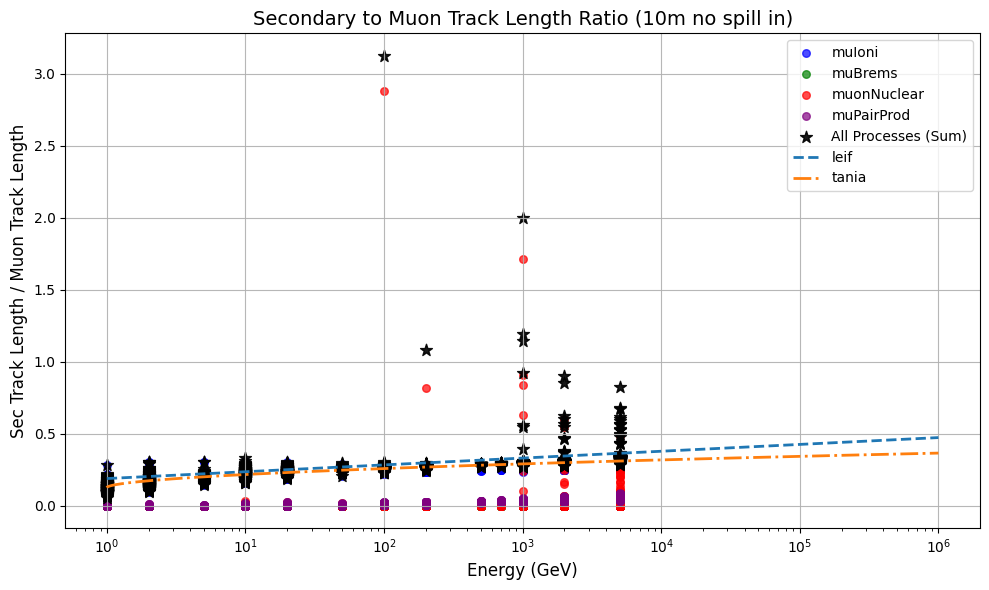

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.7,
        s=30  # point size
    )

# Here's the correct approach for the sum:
# We need to calculate the sum of the numerator for all processes at each energy level
# and divide by the same muon track length

# First, let's create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Plot the sum as a fifth type of point
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='black',
    label='All Processes (Sum)',
    marker='*',
    alpha=0.9,
    s=80  # Larger size for visibility
)


def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')


# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (10m no spill in)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)

plt.tight_layout()
plt.show()

Maximum total ratio: 3.123791252238505 and index: 2375


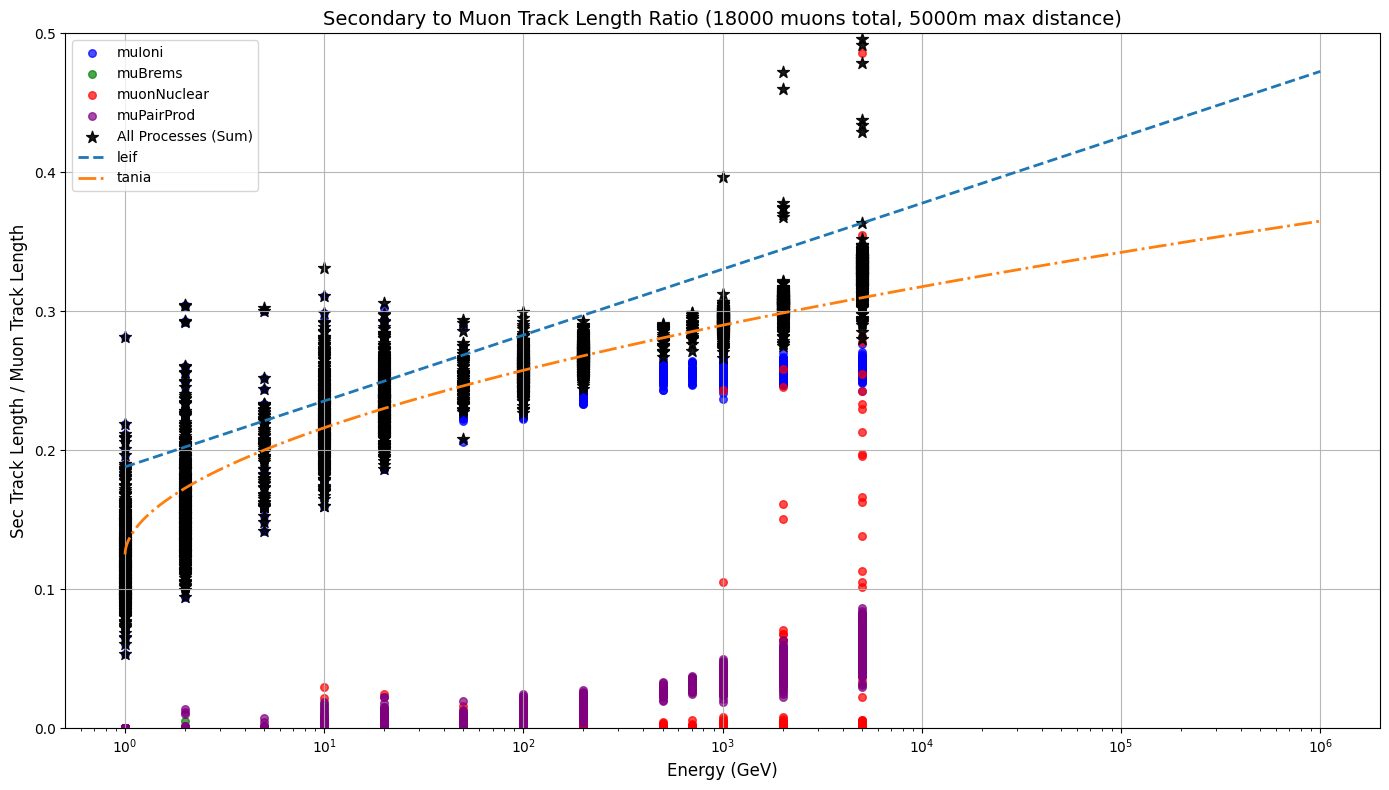

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.7,
        s=30  # point size
    )

# Here's the correct approach for the sum:
# We need to calculate the sum of the numerator for all processes at each energy level
# and divide by the same muon track length

# First, let's create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Plot the sum as a fifth type of point
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='black',
    label='All Processes (Sum)',
    marker='*',
    alpha=0.9,
    s=80  # Larger size for visibility
)


def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')


# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (18000 muons total, 5000m max distance)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

Maximum total ratio: 3.123791252238505 and index: 2375


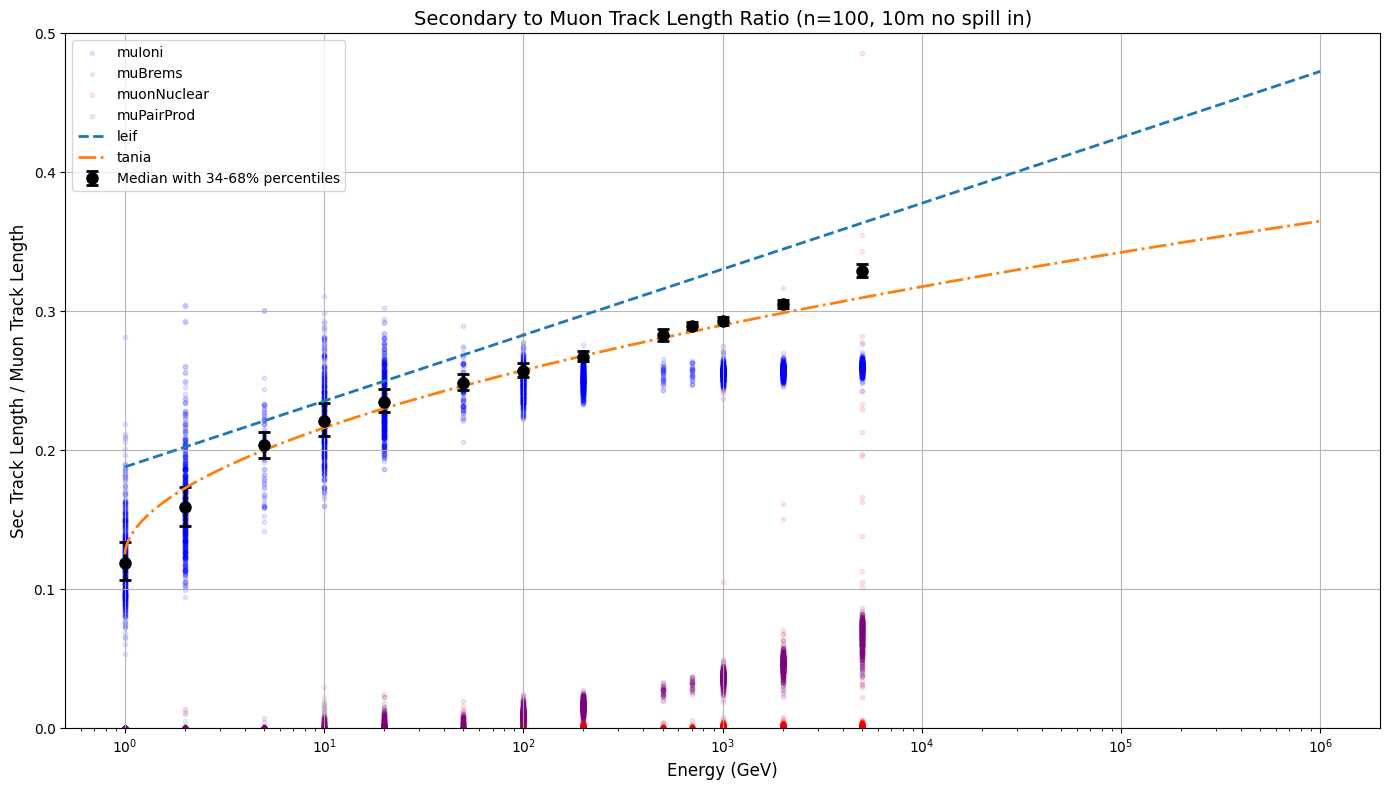

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}



# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.1,
        s=10  # point size
    )

# Create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Instead of plotting individual points, we'll calculate medians and percentiles by energy
energy_grouped = merged_data.groupby('energy_value')

# Calculate median and percentiles for each energy group
medians = []
lower_errors = []
upper_errors = []
energy_vals = []

for energy, group in energy_grouped:
    # Only include groups with enough data points
    if len(group) >= 3:  # Require at least 3 points for meaningful statistics
        median = group['total_ratio'].median()
        p34 = np.percentile(group['total_ratio'], 34)
        p68 = np.percentile(group['total_ratio'], 68)
        
        medians.append(median)
        lower_errors.append(median - p34)
        upper_errors.append(p68 - median)
        energy_vals.append(energy)

# Convert to numpy arrays for easier handling
medians = np.array(medians)
lower_errors = np.array(lower_errors)
upper_errors = np.array(upper_errors)
energy_vals = np.array(energy_vals)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    label='Median with 34-68% percentiles',
    markersize=8,
    elinewidth=2,
    capthick=2
)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (n=100, 10m no spill in)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

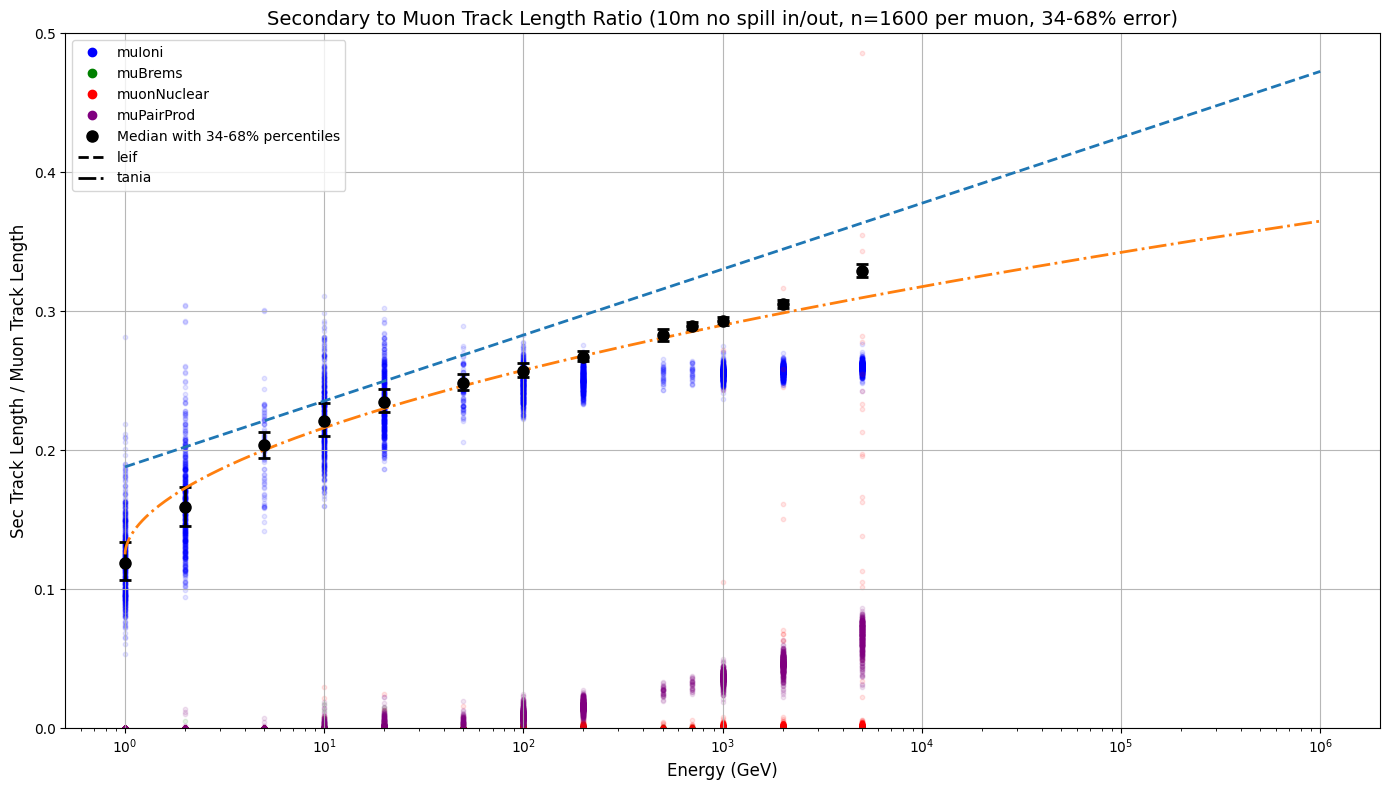

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

# Your existing code for creating the scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, label=process)
    legend_handles.append(handle)

# Rest of your code for creating merged data and calculating statistics
# ...

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',
    capsize=4,
    markersize=8,
    elinewidth=2,
    capthick=2
)

# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker='o', linestyle='None',
                         markersize=8, label='Median with 34-68% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
# ...

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')



def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

legend_handles.append(model1_line)
legend_handles.append(model2_line)

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')


# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (10m no spill in/out, n=1600 per muon, 34-68% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.savefig('prop_10m_muon_all_errors.pdf')
plt.tight_layout()
plt.show()

Number of points per energy value:
Energy: 1 GeV - 500 points
Energy: 2 GeV - 500 points
Energy: 5 GeV - 81 points
Energy: 10 GeV - 500 points
Energy: 20 GeV - 500 points
Energy: 50 GeV - 84 points
Energy: 100 GeV - 500 points
Energy: 200 GeV - 500 points
Energy: 500 GeV - 32 points
Energy: 700 GeV - 27 points
Energy: 1000 GeV - 500 points
Energy: 2000 GeV - 500 points
Energy: 5000 GeV - 458 points


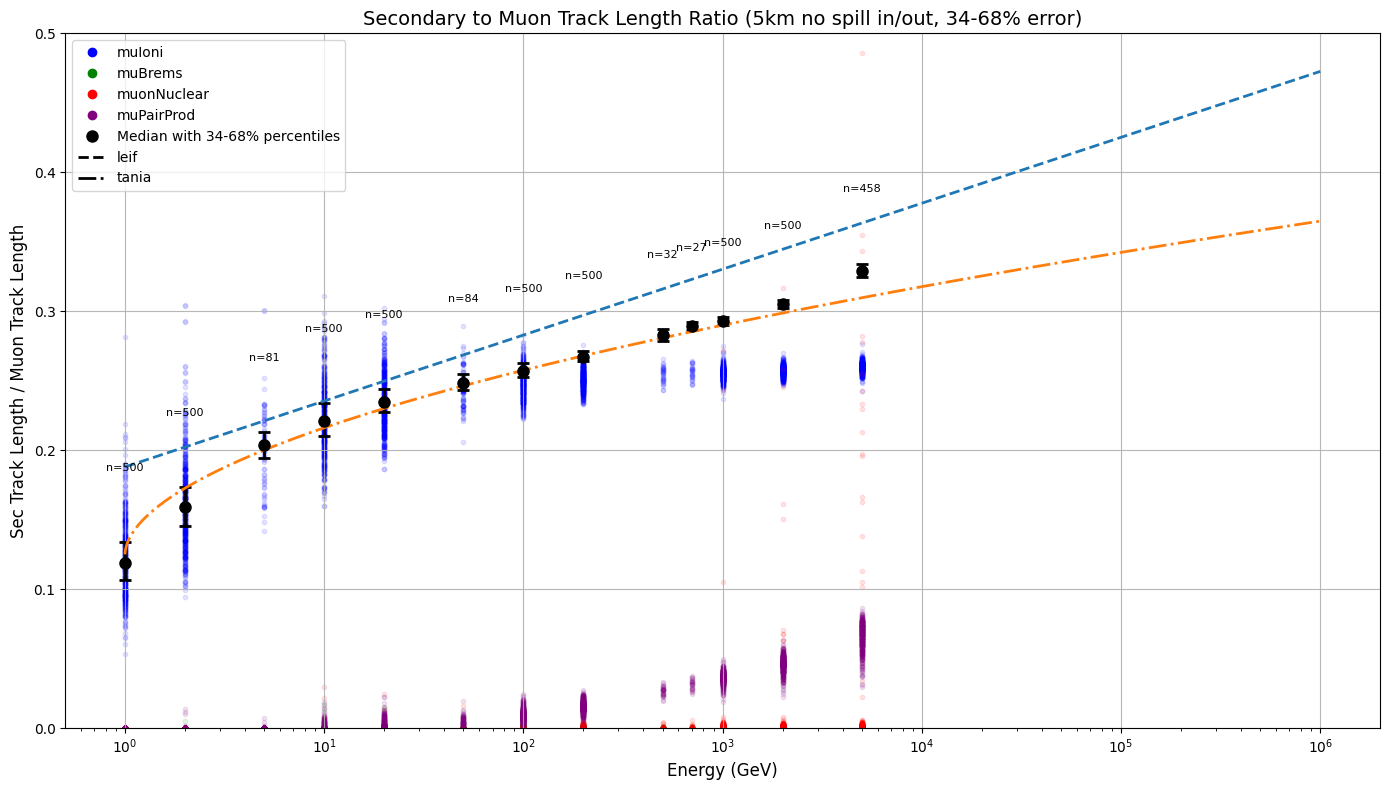

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

# Your existing code for creating the scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Count and print the number of points per energy value
energy_counts = merged_data['energy_value'].value_counts().sort_index()
print("Number of points per energy value:")
for energy, count in energy_counts.items():
    print(f"Energy: {energy} GeV - {count} points")

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, label=process)
    legend_handles.append(handle)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',
    capsize=4,
    markersize=8,
    elinewidth=2,
    capthick=2
)

# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker='o', linestyle='None',
                         markersize=8, label='Median with 34-68% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')
legend_handles.append(model1_line)
legend_handles.append(model2_line)

plt.plot(energies, model1_values, linewidth=2, linestyle='--')
plt.plot(energies, model2_values, linewidth=2, linestyle='-.')

# Add sample sizes to the plot
for energy, count in energy_counts.items():
    if energy in energy_vals:
        idx = np.where(energy_vals == energy)[0][0]
        plt.text(energy, medians[idx] + upper_errors[idx] + 0.05, 
                f"n={count}", ha='center', va='bottom', fontsize=8)

# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (5km no spill in/out, 34-68% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('prop_5k_error_bars.pdf')
plt.show()

Maximum total ratio: 3.123791252238505 and index: 2375


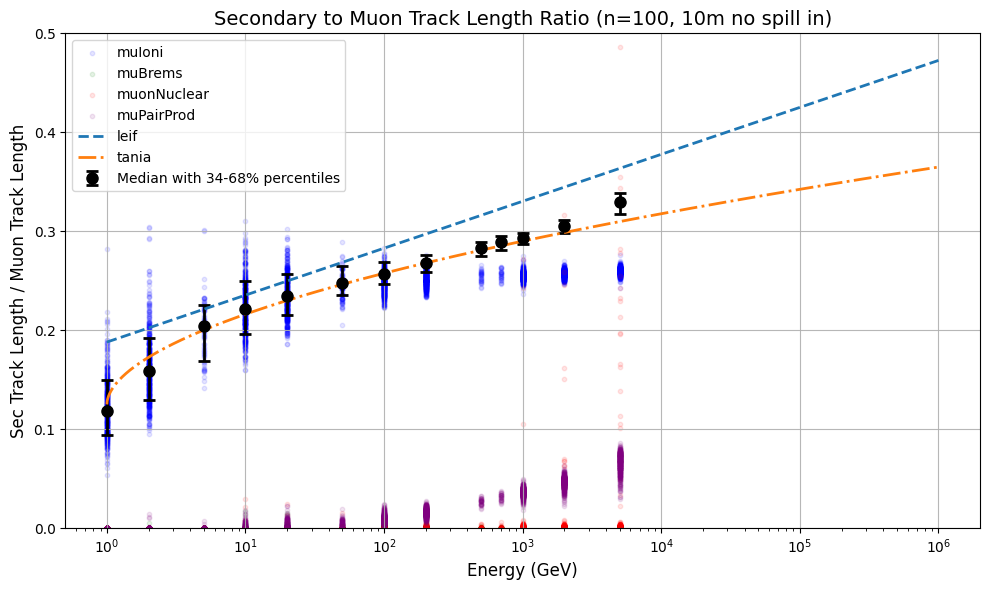

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}



# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.1,
        s=10  # point size
    )

# Create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Instead of plotting individual points, we'll calculate medians and percentiles by energy
energy_grouped = merged_data.groupby('energy_value')

# Calculate median and percentiles for each energy group
medians = []
lower_errors = []
upper_errors = []
energy_vals = []

for energy, group in energy_grouped:
    # Only include groups with enough data points
    if len(group) >= 3:  # Require at least 3 points for meaningful statistics
        median = group['total_ratio'].median()
        p34 = np.percentile(group['total_ratio'], 16)
        p68 = np.percentile(group['total_ratio'], 84)
        
        medians.append(median)
        lower_errors.append(median - p34)
        upper_errors.append(p68 - median)
        energy_vals.append(energy)

# Convert to numpy arrays for easier handling
medians = np.array(medians)
lower_errors = np.array(lower_errors)
upper_errors = np.array(upper_errors)
energy_vals = np.array(energy_vals)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    label='Median with 34-68% percentiles',
    markersize=8,
    elinewidth=2,
    capthick=2
)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (n=100, 10m no spill in)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

Number of points per energy value:
Energy: 1 GeV - 500 points
Energy: 2 GeV - 500 points
Energy: 5 GeV - 81 points
Energy: 10 GeV - 500 points
Energy: 20 GeV - 500 points
Energy: 50 GeV - 84 points
Energy: 100 GeV - 500 points
Energy: 200 GeV - 500 points
Energy: 500 GeV - 32 points
Energy: 700 GeV - 27 points
Energy: 1000 GeV - 500 points
Energy: 2000 GeV - 500 points
Energy: 5000 GeV - 458 points


/tmp/ipykernel_1138865/3007839317.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


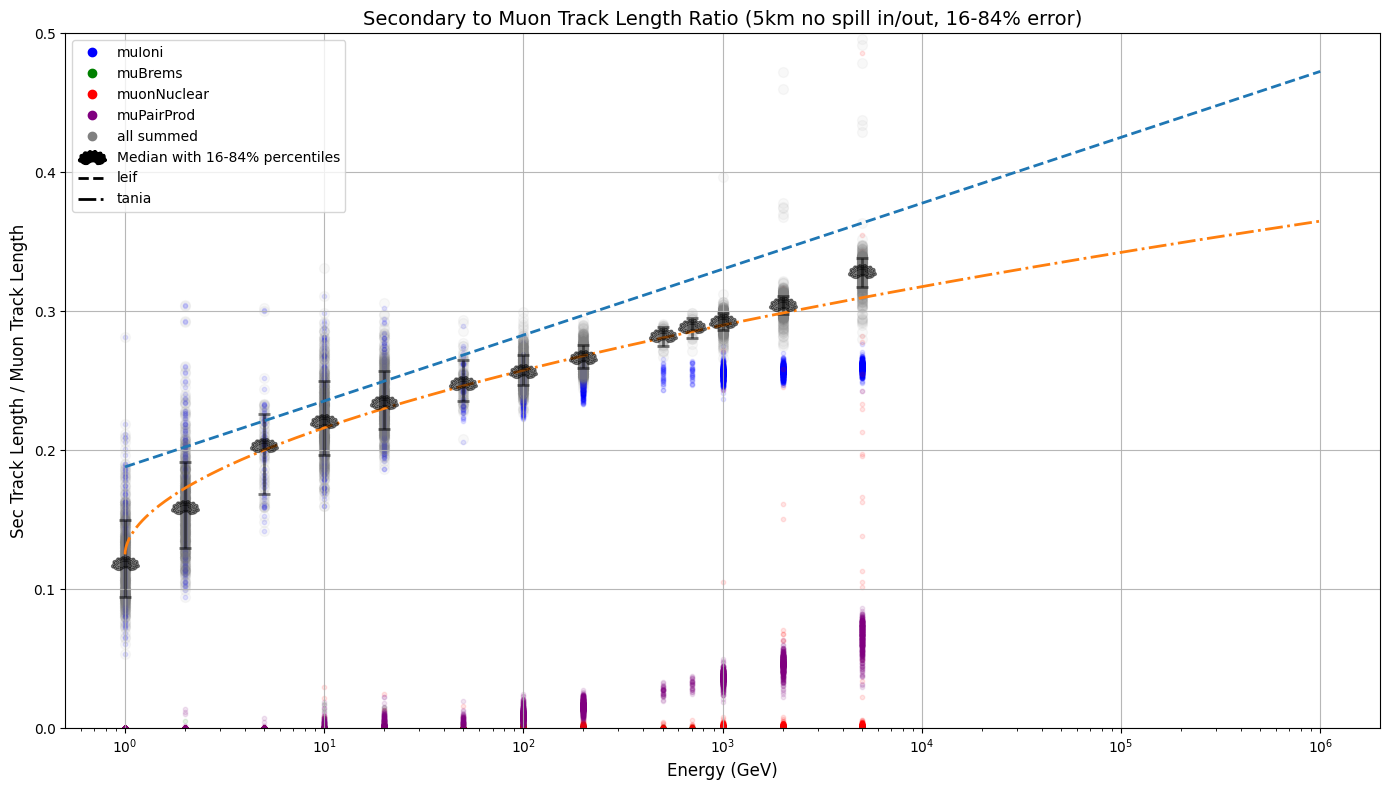

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

# Create the scatter plot
plt.figure(figsize=(14, 8))

# Filter data for energy < 1e5
filtered_data = merged_data[merged_data['energy_value'] < 1e7]
filtered_dfs_all = dfs['all'][dfs['all']['muon_kinetic_energy [GeV]'] < 1e7]

# Filter arrays for medians and error bars
energy_mask = energy_vals < 1e5
filtered_energy_vals = energy_vals[energy_mask]
filtered_medians = medians[energy_mask]
filtered_lower_errors = lower_errors[energy_mask]
filtered_upper_errors = upper_errors[energy_mask]

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple',
    'all summed': 'grey'
}

# Count and print the number of points per energy value
energy_counts = filtered_data['energy_value'].value_counts().sort_index()
print("Number of points per energy value:")
for energy, count in energy_counts.items():
    print(f"Energy: {energy} GeV - {count} points")

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = filtered_dfs_all[filtered_dfs_all['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, label=process)
    legend_handles.append(handle)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    marker=pasta.creste,
    label='Median with 34-68% percentiles',
    markersize=20,
    alpha=0.5,
    elinewidth=2,
    capthick=2
)

# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker=pasta.creste, linestyle='None',
                         markersize=20, label='Median with 16-84% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

# Filter model energy range to match data (< 1e5)
energies = np.logspace(np.log10(1), np.log10(1e6), 5000)
model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')
legend_handles.append(model1_line)
legend_handles.append(model2_line)

# Plot all processes sum (after filtering)
plt.scatter(
    filtered_data['energy_value'],
    filtered_data['total_ratio'],
    c='grey',
    label='All Processes (Sum)',
    marker='o',  # Using standard marker instead of pasta.penne
    alpha=0.05,
    s=50  # Larger size for visibility
)


plt.plot(energies, model1_values, linewidth=2, linestyle='--')
plt.plot(energies, model2_values, linewidth=2, linestyle='-.')

# # Add sample sizes to the plot
# for energy, count in energy_counts.items():
#     if energy in filtered_energy_vals:
#         idx = np.where(filtered_energy_vals == energy)[0][0]
#         plt.text(energy, filtered_medians[idx] + filtered_upper_errors[idx] + 0.05,
#                 f"n={count}", ha='center', va='bottom', fontsize=8)

# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (5km no spill in/out, 16-84% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('prop_5km_creste.pdf')
plt.show()

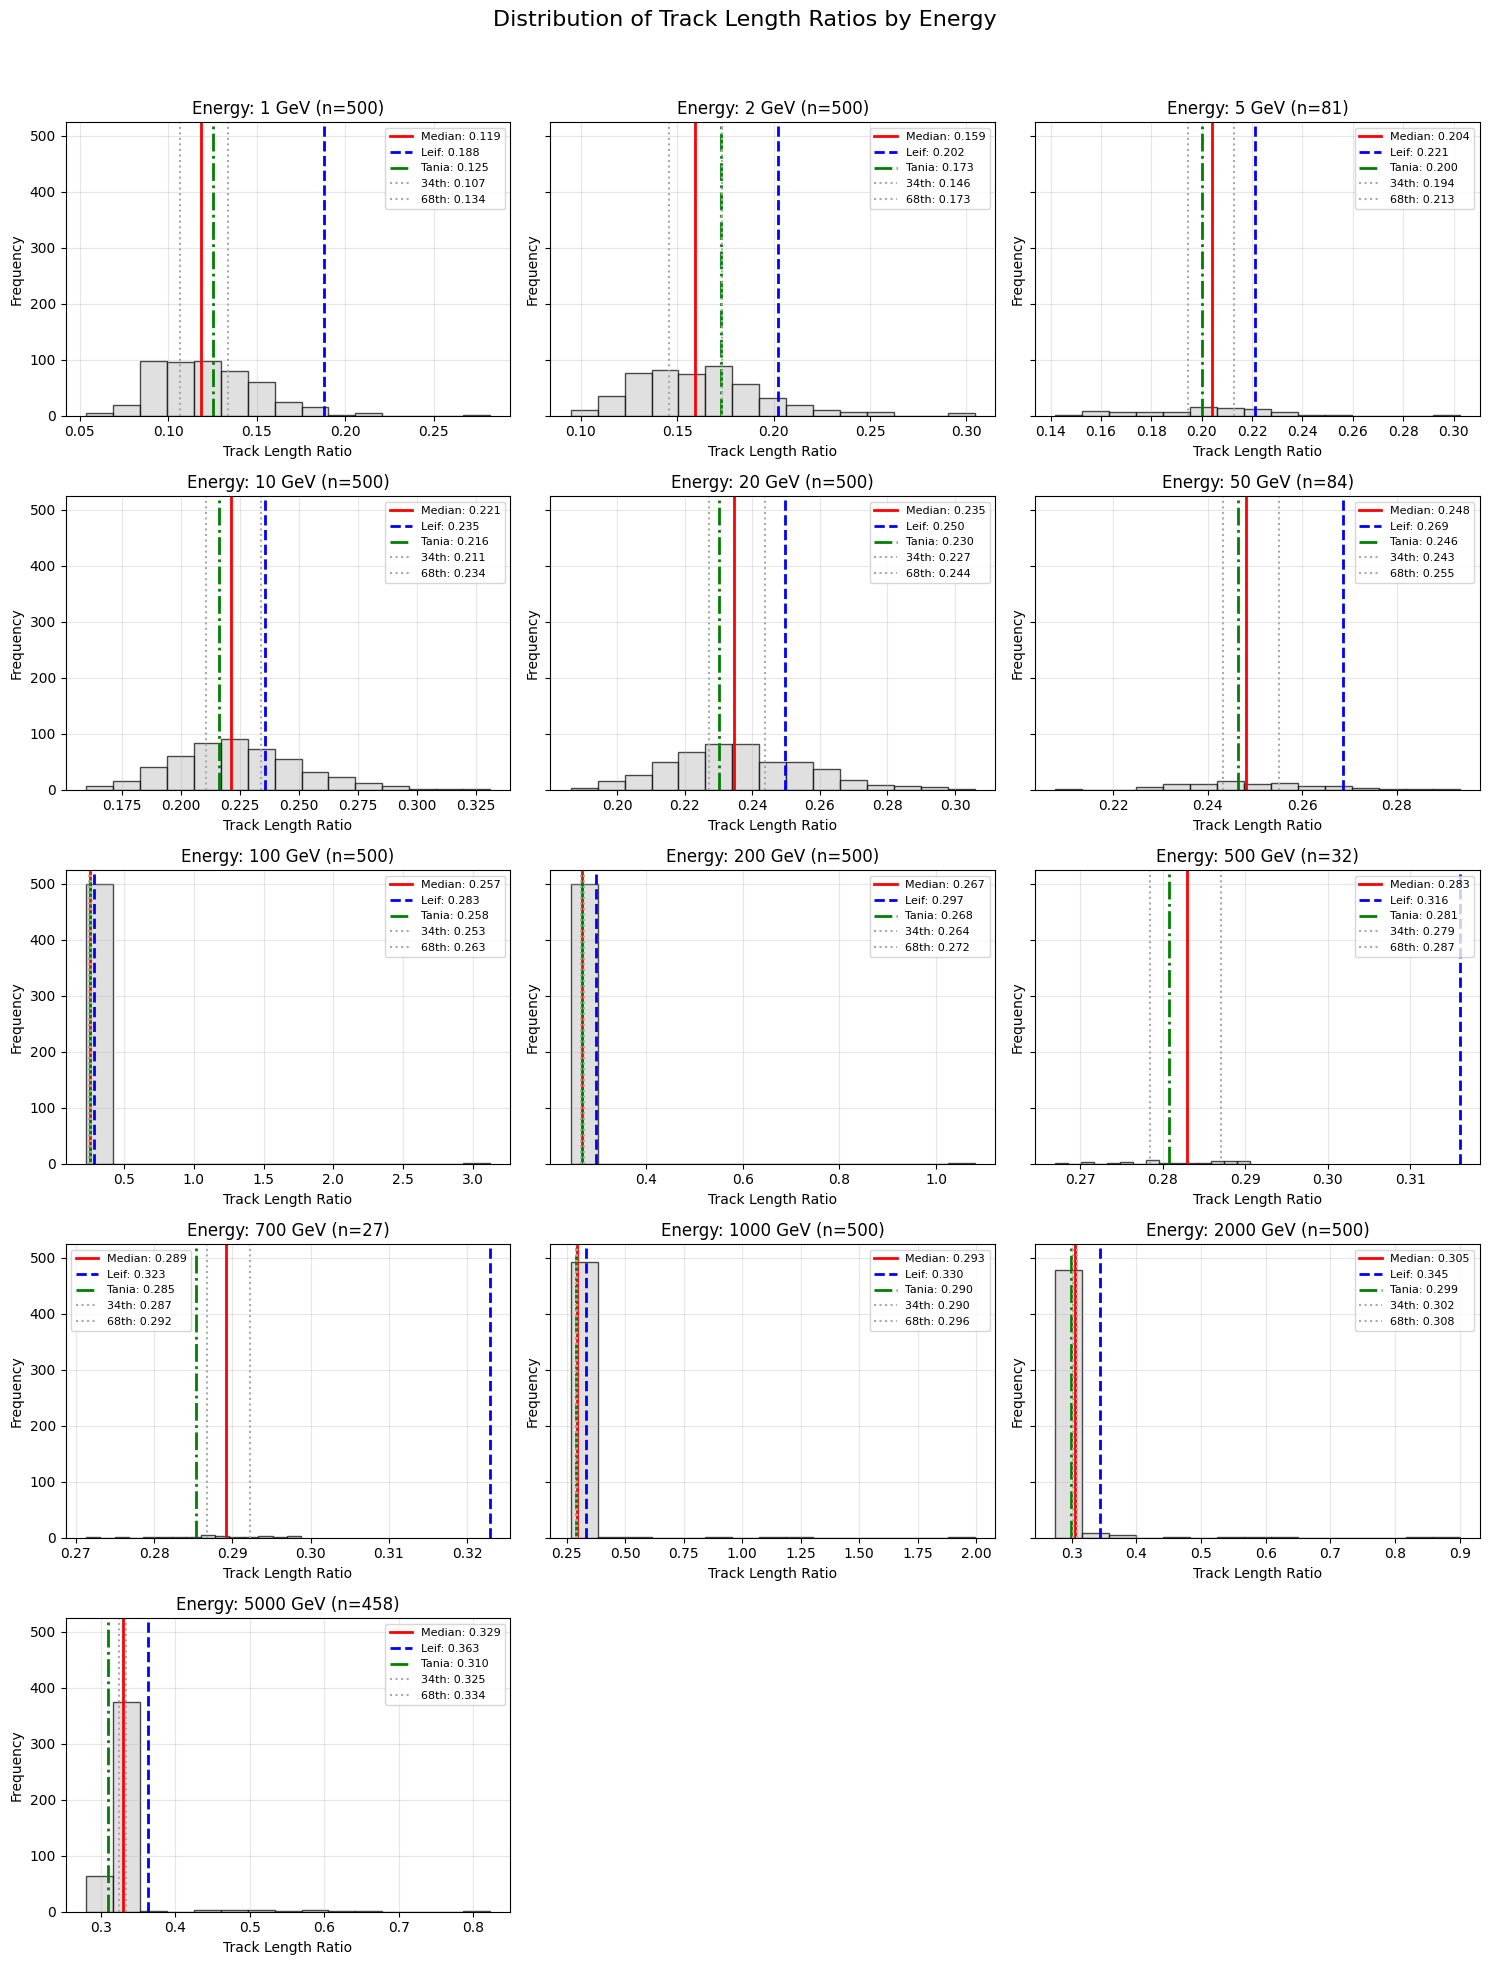

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Make sure we have the proper ratio calculated
merged_data = merged_data.copy()  # Use the merged_data from previous calculations

# Get unique energy values and sort them
unique_energies = sorted(merged_data['energy_value'].unique())

# Determine grid size based on number of unique energies
n_energies = len(unique_energies)
n_cols = min(3, n_energies)  # Maximum 3 columns
n_rows = math.ceil(n_energies / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)
fig.suptitle('Distribution of Track Length Ratios by Energy', fontsize=16)

# Flatten axs if it's a multi-dimensional array
if n_rows > 1 or n_cols > 1:
    axs = axs.flatten()
else:
    axs = [axs]  # Make it iterable if there's only one subplot

# Color for the model lines
model_colors = {'leif': 'blue', 'tania': 'green'}

# Loop through each energy and create a histogram
for i, energy in enumerate(unique_energies):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        # Filter data for this energy
        energy_data = merged_data[merged_data['energy_value'] == energy]
        
        # Create histogram
        axs[i].hist(energy_data['total_ratio'], bins=15, alpha=0.7, color='lightgray', edgecolor='black')
        
        # Add vertical line for median
        median = energy_data['total_ratio'].median()
        axs[i].axvline(x=median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.3f}')
        
        # Add vertical lines for the model predictions
        model1_val = model1(energy)
        model2_val = model2(energy)
        axs[i].axvline(x=model1_val, color=model_colors['leif'], linestyle='--', linewidth=2, label=f'Leif: {model1_val:.3f}')
        axs[i].axvline(x=model2_val, color=model_colors['tania'], linestyle='-.', linewidth=2, label=f'Tania: {model2_val:.3f}')
        
        # Add percentile lines
        p34 = np.percentile(energy_data['total_ratio'], 34)
        p68 = np.percentile(energy_data['total_ratio'], 68)
        axs[i].axvline(x=p34, color='darkgray', linestyle=':', linewidth=1.5, label=f'34th: {p34:.3f}')
        axs[i].axvline(x=p68, color='darkgray', linestyle=':', linewidth=1.5, label=f'68th: {p68:.3f}')
        
        # Set title and labels
        axs[i].set_title(f'Energy: {energy} GeV (n={len(energy_data)})')
        axs[i].set_xlabel('Track Length Ratio')
        axs[i].set_ylabel('Frequency')
        axs[i].legend(fontsize=8)
        axs[i].grid(alpha=0.3)

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
plt.show()